<a href="https://www.kaggle.com/code/thiagosalesfreireluz/exoplanet-random-subspace?scriptVersionId=224344979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.metrics import confusion_matrix
import numpy as np # linear algebra
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from numpy.random import seed
import time



In [2]:
data = pd.read_csv('../input/kepler-exoplanet-search-results/cumulative.csv')

In [3]:
# getting data
df = data

# Drop unused columns
df = df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score'], axis=1)
  
# Limit target values to CANDIDATE and CONFIRMED
false_positive_rows = df.query("koi_disposition == 'FALSE POSITIVE'").index
df = df.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
df['koi_disposition'] = df['koi_disposition'].map({"CANDIDATE":1,"CONFIRMED":0})
    
# Drop columns with all missing values
df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

# Fill remaining missing values
df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
for column in df.columns[df.isna().sum() > 0]:
    df[column] = df[column].fillna(df[column].mean())



# One-hot encode koi_tce_delivname column
delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
df = pd.concat([df, delivname_dummies], axis=1)
df = df.drop('koi_tce_delivname', axis=1)

# Split df into X and y
y = df['koi_disposition']
X = df.drop('koi_disposition', axis=1)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
X_train, X_test, y_train, y_test




(      koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  \
 1673      -0.071134      -0.117116        -0.0355      -0.017742   -0.037165   
 1239      -0.071134      -0.117116        -0.0355      -0.017742   -0.004275   
 3589      -0.071134      -0.117116        -0.0355      -0.017742    0.174458   
 415       -0.071134      -0.117116        -0.0355      -0.017742   -0.037962   
 2925      -0.071134      -0.117116        -0.0355      -0.017742    0.010035   
 ...             ...            ...            ...            ...         ...   
 2895      -0.071134      -0.117116        -0.0355      -0.017742   -0.035650   
 2763      -0.071134      -0.117116        -0.0355      -0.017742   -0.031798   
 905       -0.071134      -0.117116        -0.0355      -0.017742   -0.026434   
 3980      -0.071134      -0.117116        -0.0355      -0.017742   -0.034204   
 235       -0.071134      -0.117116        -0.0355      -0.017742   -0.037964   
 
       koi_period_err1  ko

In [4]:
# define the random subspace ensemble model
clf = BaggingClassifier(n_estimators = 1000, max_samples = 0.1, max_features = 1.0)

In [5]:
clf.fit(X_train, y_train)


BaggingClassifier(max_samples=0.1, n_estimators=1000)

In [6]:
def get_classifications(y_test, y_pred, positive_label=1):
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == positive_label:
            if y_p == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if y_p == positive_label:
                fp += 1
            else:
                tn += 1
    
    return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + fn + fp + tn)
    return acc

def get_precision(tp, fn, fp, tn):
    precision = tp / (tp + fp)
    return precision

def get_recall(tp, fn, fp, tn):
    recall = tp / (tp + fn)
    return recall

def get_f1_score(tp, fn, fp, tn):
    precision = get_precision(tp, fn, fp, tn)
    recall = get_recall(tp, fn, fp, tn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def get_sensitivity(tp, fn, fp, tn):
    sensitivity = tp / (tp + fn)
    return sensitivity

def get_specificity(tp, fn, fp, tn):
    specificity = tn / (tn + fp)
    return specificity

In [7]:
seed(0)

In [8]:
#Measure time
start_time = time.time()

In [9]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.8021978  0.85682819 0.80396476 0.83920705 0.82819383 0.79515419
 0.81938326 0.83259912 0.82599119 0.80176211 0.81978022 0.83259912
 0.79295154 0.83259912 0.80396476 0.83259912 0.83480176 0.81938326
 0.83480176 0.79735683 0.82417582 0.83700441 0.82819383 0.79735683
 0.82378855 0.81057269 0.82819383 0.81497797 0.81057269 0.83920705
 0.83736264 0.81277533 0.81718062 0.83920705 0.81718062 0.81497797
 0.79295154 0.83700441 0.83920705 0.80176211 0.83296703 0.81938326
 0.83480176 0.81938326 0.7907489  0.82819383 0.84361233 0.8215859
 0.8061674  0.8061674 ]
Accuracy: 0.8207 (0.0156)


In [10]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('sensitivity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.71555556 0.81696429 0.77232143 0.84       0.8        0.76444444
 0.78666667 0.80888889 0.76444444 0.74666667 0.78222222 0.79464286
 0.74107143 0.80444444 0.79111111 0.76888889 0.78666667 0.78222222
 0.81777778 0.75111111 0.79111111 0.78571429 0.82142857 0.72888889
 0.79555556 0.76       0.76888889 0.80888889 0.77777778 0.83111111
 0.8        0.78125    0.78125    0.77777778 0.80888889 0.76
 0.75111111 0.79111111 0.82666667 0.76888889 0.78222222 0.75446429
 0.84375    0.78666667 0.76444444 0.79111111 0.82666667 0.76444444
 0.77777778 0.77777778]
sensitivity: 0.7844 (0.0272)


In [11]:
specificity = make_scorer(recall_score, pos_label=0)

In [12]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, cv=cv, scoring = specificity, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('specificity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.85652174 0.87826087 0.84347826 0.83842795 0.8558952  0.80786026
 0.8558952  0.84716157 0.86899563 0.86026201 0.85652174 0.86521739
 0.83913043 0.83406114 0.80349345 0.88209607 0.88646288 0.8558952
 0.86899563 0.82532751 0.84347826 0.89565217 0.83043478 0.86026201
 0.83842795 0.86462882 0.87336245 0.83842795 0.82532751 0.84279476
 0.86521739 0.83913043 0.86521739 0.89082969 0.8209607  0.86026201
 0.8209607  0.87336245 0.8558952  0.83842795 0.89565217 0.88695652
 0.83478261 0.86899563 0.82532751 0.8558952  0.85152838 0.88209607
 0.82532751 0.83406114]
specificity: 0.8527 (0.0223)


In [13]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('precision: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.83589744 0.86448598 0.83173077 0.82969432 0.84976526 0.80184332
 0.84761905 0.84186047 0.86432161 0.84079602 0.85148515 0.84722222
 0.81862745 0.83333333 0.81081081 0.85784314 0.86699507 0.83962264
 0.84331797 0.80465116 0.83018868 0.88059701 0.81333333 0.84102564
 0.84037559 0.83919598 0.85294118 0.83796296 0.82407407 0.84
 0.86057692 0.83412322 0.83809524 0.87562189 0.8125     0.84313725
 0.8047619  0.86764706 0.85185185 0.81516588 0.87128713 0.86666667
 0.82608696 0.84210526 0.81132075 0.85167464 0.83928571 0.85714286
 0.81481481 0.8271028 ]
precision: 0.8399 (0.0195)


In [14]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('f1 score: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.77884615 0.8428246  0.79814385 0.83741648 0.82648402 0.78555305
 0.8091954  0.83446712 0.82134571 0.79625293 0.81018519 0.82298851
 0.77464789 0.82326622 0.80444444 0.81042654 0.82325581 0.8173516
 0.8280543  0.79176201 0.80549199 0.83568075 0.8206278  0.78588235
 0.81179138 0.78672986 0.81690141 0.80717489 0.80272109 0.83482143
 0.82488479 0.80182232 0.80742459 0.82742317 0.80623608 0.80278422
 0.77522936 0.82242991 0.83446712 0.78983834 0.82075472 0.80851064
 0.83111111 0.81464531 0.77241379 0.82488479 0.83555556 0.80660377
 0.79638009 0.80725624]
f1 score: 0.8111 (0.0179)


In [15]:
# Print time
print("--- %s seconds ---" % (time.time() - start_time))

--- 1312.3424608707428 seconds ---


In [16]:
y_pred = clf.predict(X_test)
print(" Accuracy: {:.3f}%".format(get_accuracy(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" Sensitivity: {:.3f}%".format(get_sensitivity(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" Specificity: {:.3f}%".format(get_specificity(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" Precision: {:.3f}%".format(get_precision(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" F1 Score: {:.5f}".format(get_f1_score(*get_classifications(y_test, y_pred))))

 Accuracy: 81.365%
 Sensitivity: 76.935%
 Specificity: 85.511%
 Precision: 83.251%
 F1 Score: 0.79968


In [17]:
RF = RandomForestClassifier()   # initialising Random Forest

AD = AdaBoostClassifier()

# define the random subspace ensemble model
model2 = BaggingClassifier(base_estimator = RF, bootstrap=False, max_features=15)

model_random_subspace = model2.fit(X_train, y_train)
pred = model_random_subspace.predict(X_test)


acc = accuracy_score(y_test, pred)
print('Accuracy of random subspace:', acc * 100)


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of random subspace: 80.77769625825385


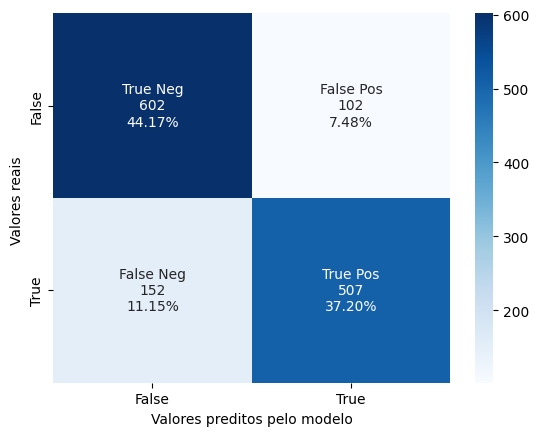

In [18]:
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.JPEG')
plt.show()


In [19]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
print(n_estimators)
max_samples = [0.1,1.0,10]
max_features = [0.1,1.0,10]

[10, 257, 505, 752, 1000]


In [20]:
# Exemplo dos parâmetros que quero testar.
parametros = {'n_estimators': n_estimators,
              'max_samples': max_samples,
              'max_features' : max_features}

In [21]:
from sklearn.model_selection import GridSearchCV
# Criação do objeto do GridSearchCV.
grid = GridSearchCV(estimator = clf,          # É o nosso AdaBoost.
                    param_grid = parametros,  # É aquele dicionário com valores para serem testados.
                    scoring = 'accuracy',           # Arbitrariamente escolhi o accuracy, adiante explico com detalhes.
                    cv = 5)  


In [22]:
# Treinando o grid.
#grid.fit(X_train, y_train)

# Imprimindo os resultados.
#pd.DataFrame(grid.cv_results_)


In [23]:
# Imprimindo os resultados.
#pd.DataFrame(grid.cv_results_)

In [24]:
# Imprime os parâmetros que produziram o ".best_score_".
#grid.best_params_

In [25]:
# Imprime colunas de interesse.
#pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]

In [26]:
# Imprimindo o score.
#grid.best_score_